In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import random
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import copy
import math
from sklearn.manifold import TSNE

%matplotlib inline

# Set Seed
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

BATCH_SIZE = 128

In [3]:
transform = transforms.ToTensor()

# Download MNIST
train_dataset = datasets.MNIST(
    root="../data", train=True, download=True, transform=transform
)
test_dataset = datasets.MNIST(
    root="../data", train=False, download=True, transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



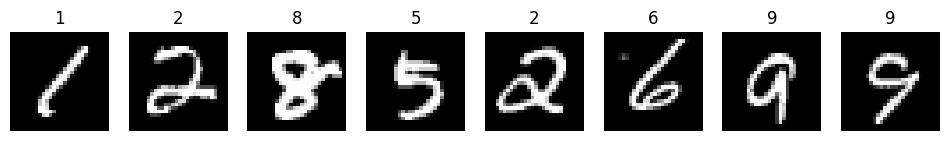

In [4]:
# Test the download
images, labels = next(iter(train_loader))
fig, axes = plt.subplots(1, 8, figsize=(12, 2))
for i, ax in enumerate(axes):
    ax.imshow(images[i].squeeze(), cmap="gray")
    ax.set_title(str(labels[i].item()))
    ax.axis("off")
plt.show()


In [25]:
class VAE(nn.Module):
    def __init__(self, input_dim=28*28, hidden_dim=400, latent_dim=20):
        super().__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        # x shape: [B, 1, 28, 28] or [B, 784]
        if x.dim() == 4:
            x = x.view(x.size(0), -1)
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decode(self, z):
        h = F.relu(self.fc3(z))
        x_hat = torch.sigmoid(self.fc4(h))  # outputs in (0,1) for BCE
        return x_hat

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

In [6]:
def vae_loss(recon_x, x, mu, logvar, reduction='sum'):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction=reduction)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD, BCE, KLD

In [ ]:
model = VAE(latent_dim=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 50
for epoch in range(1, num_epochs+1):
    model.train()
    train_loss = 0.0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)  # shape [B,1,28,28]
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss, bce, kl = vae_loss(recon_batch, data, mu, logvar, reduction='sum')
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}, Avg loss per datapoint: {avg_loss:.4f}")


NameError: name 'train_loader' is not defined

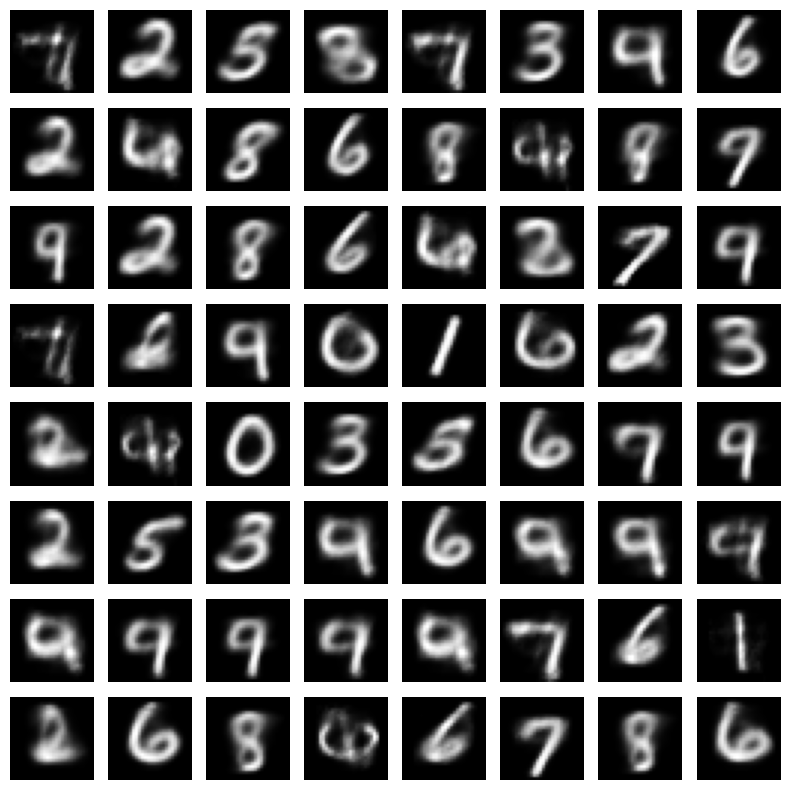

In [54]:
with torch.no_grad():
    z = torch.randn(64, 2).to(device)
    samples = model.decode(z)  # shape [64, 784], values in (0,1)
    samples = samples.view(-1, 1, 28, 28).cpu()


fig, axes = plt.subplots(8, 8, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(samples[i].squeeze(), cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()


In [7]:
class CVAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20, num_classes=10):
        super(CVAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # Encoder
        # Input = image + one-hot label
        self.fc1 = nn.Linear(input_dim + num_classes, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        # Input = latent vector + one-hot label
        self.fc3 = nn.Linear(latent_dim + num_classes, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x, y):
        # y: integer labels -> one-hot encode
        y_onehot = F.one_hot(y, num_classes=self.num_classes).float()
        # concat along feature dim
        xy = torch.cat([x, y_onehot], dim=1)
        h = F.relu(self.fc1(xy))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        y_onehot = F.one_hot(y, num_classes=self.num_classes).float()
        zy = torch.cat([z, y_onehot], dim=1)
        h = F.relu(self.fc3(zy))
        out = torch.sigmoid(self.fc4(h))
        return out

    def forward(self, x, y):
        mu, logvar = self.encode(x, y)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, y)
        return recon_x, mu, logvar

In [ ]:
model2 = CVAE(latent_dim=2).to(device)
optimizer2 = optim.Adam(model2.parameters(), lr=1e-3)
num_epochs = 50

for epoch in range(1, num_epochs + 1):
    model2.train()
    train_loss = 0.0
    for x, y in train_loader:
        x = x.view(-1, 784).to(device)
        y = y.to(device)
        optimizer2.zero_grad()
        recon_x, mu, logvar = model2(x, y)
        loss, BCE, KLD = vae_loss(recon_x, x, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer2.step()

    avg_loss = train_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}, Avg loss per datapoint: {avg_loss:.4f}")

Epoch 1, Avg loss per datapoint: 178.7701
Epoch 2, Avg loss per datapoint: 147.9138
Epoch 3, Avg loss per datapoint: 142.8785
Epoch 4, Avg loss per datapoint: 140.1312
Epoch 5, Avg loss per datapoint: 138.3151
Epoch 6, Avg loss per datapoint: 136.9730
Epoch 7, Avg loss per datapoint: 135.9775
Epoch 8, Avg loss per datapoint: 135.2040
Epoch 9, Avg loss per datapoint: 134.5367
Epoch 10, Avg loss per datapoint: 134.0056
Epoch 11, Avg loss per datapoint: 133.5513
Epoch 12, Avg loss per datapoint: 133.1773
Epoch 13, Avg loss per datapoint: 132.8472
Epoch 14, Avg loss per datapoint: 132.5485
Epoch 15, Avg loss per datapoint: 132.3056
Epoch 16, Avg loss per datapoint: 132.0728
Epoch 17, Avg loss per datapoint: 131.8715
Epoch 18, Avg loss per datapoint: 131.7364
Epoch 19, Avg loss per datapoint: 131.5836
Epoch 20, Avg loss per datapoint: 131.4027
Epoch 21, Avg loss per datapoint: 131.2473
Epoch 22, Avg loss per datapoint: 131.1629
Epoch 23, Avg loss per datapoint: 131.0022
Epoch 24, Avg loss p

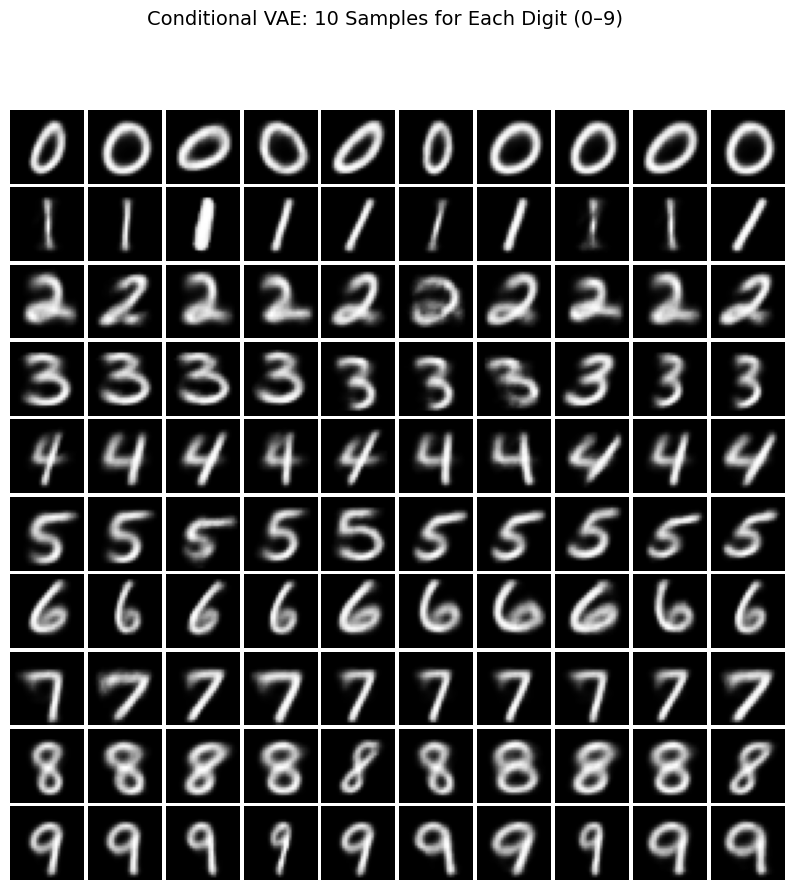

In [72]:
model2.eval()
n_samples_per_digit = 10
num_classes = 10

with torch.no_grad():
    z = torch.randn(num_classes * n_samples_per_digit, model2.latent_dim).to(device)
    y = torch.arange(0, num_classes).repeat_interleave(n_samples_per_digit).to(device)
    samples = model2.decode(z, y).view(-1, 1, 28, 28).cpu()

fig, axes = plt.subplots(num_classes, n_samples_per_digit, figsize=(10, 10))
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for i in range(num_classes):
    for j in range(n_samples_per_digit):
        ax = axes[i, j]
        ax.imshow(samples[i * n_samples_per_digit + j][0], cmap='gray')
        ax.axis('off')

plt.suptitle("Conditional VAE: 10 Samples for Each Digit (0–9)", fontsize=14)
plt.show()

In [8]:
# Load trained models

model = VAE(latent_dim=2).to(device)
model2 = CVAE(latent_dim=2).to(device)  

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-3)

checkpoint1 = torch.load("models/UVAE_checkpoint.pt", map_location=device)
model.load_state_dict(checkpoint1['model_state_dict'])
optimizer.load_state_dict(checkpoint1['optimizer_state_dict'])

checkpoint2 = torch.load("models/CVAE_checkpoint.pt", map_location=device)
model2.load_state_dict(checkpoint2['model_state_dict'])
optimizer2.load_state_dict(checkpoint2['optimizer_state_dict'])

print("✅ Both models have been restored successfully!")


✅ Both models have been restored successfully!


In [9]:
def compute_fisher(model, data_loader, device):
    model.eval()
    fish = {n: torch.zeros_like(p, device=p.device) for n, p in model.named_parameters()}
    total = 0
    for x, y in data_loader:
        x = x.to(device); y = y.to(device)
        b = x.size(0); total += b
        model.zero_grad()
        x_flat = x.view(b, -1)
        recon, mu, logvar = model(x_flat, y)
        loss, _, _ = vae_loss(recon, x_flat, mu, logvar, reduction='sum')
        loss.backward()
        for n, p in model.named_parameters():
            if p.grad is not None:
                fish[n] += (p.grad.detach() ** 2)
    for n in fish: fish[n] /= float(total)
    return {k: v.detach() for k, v in fish.items()}


In [10]:
def run_selective_amnesia(base_model, train_dataset, forget_classes, device, base_name="CVAE_checkpoint.pt"):
    # === Split dataset ===
    forget_indices = [i for i, (_, y) in enumerate(train_dataset) if y in forget_classes]
    retain_indices = [i for i, (_, y) in enumerate(train_dataset) if y not in forget_classes]

    forget_dataset = Subset(train_dataset, forget_indices)
    retain_dataset = Subset(train_dataset, retain_indices)

    forget_loader = DataLoader(forget_dataset, batch_size=BATCH_SIZE, shuffle=True)
    retain_loader = DataLoader(retain_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # === Compute Fisher ===
    fisher = compute_fisher(base_model, retain_loader, device)

    # === Copy model ===
    sa_model = copy.deepcopy(base_model).to(device)
    theta_star = {n: p.clone().detach() for n, p in sa_model.named_parameters()}
    optimizer = optim.Adam(sa_model.parameters(), lr=1e-3)

    # === Selective amnesia training ===
    lambda_reg = 100
    num_epochs = 30

    for epoch in range(num_epochs):
        sa_model.train()
        running = 0.0
        for x_ret, y_ret in retain_loader:
            b = x_ret.size(0)
            x_ret = x_ret.to(device)
            y_ret = y_ret.to(device)
            x_ret_flat = x_ret.view(b, -1)

            # Generate noise batch for forget classes
            x_noise = torch.rand_like(x_ret_flat, device=device)
            y_noise = torch.tensor(
                [random.choice(list(forget_classes)) for _ in range(b)],
                dtype=y_ret.dtype,
                device=device
            )

            recon_r, mu_r, logvar_r = sa_model(x_ret_flat, y_ret)
            loss_r, _, _ = vae_loss(recon_r, x_ret_flat, mu_r, logvar_r)

            recon_f, mu_f, logvar_f = sa_model(x_noise, y_noise)
            loss_f, _, _ = vae_loss(recon_f, x_noise, mu_f, logvar_f)

            # Fisher regularization
            reg = sum((fisher[name] * (p - theta_star[name]).pow(2)).sum()
                      for name, p in sa_model.named_parameters())

            loss = loss_r + loss_f + 0.5 * lambda_reg * reg

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}  Loss={running:.1f}")

    # === Save checkpoint ===
    forget_str = "_".join(map(str, sorted(forget_classes)))
    checkpoint_path = os.path.join("models", f"CVAE_forget_{forget_str}.pt")
    torch.save({
        'model_state_dict': sa_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'forget_classes': list(forget_classes)
    }, checkpoint_path)

    print(f"✅ Saved model forgetting {forget_classes} to {checkpoint_path}")

    return sa_model


In [ ]:
# Digit sets to forget
forget_tasks = [
    # --- Single digits ---
    {0}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9},

    # --- Two digits ---
    {0, 1}, {2, 3}, {4, 5}, {6, 7}, {8, 9},
    {0, 2}, {1, 3}, {2, 4}, {3, 5}, {4, 6},
    {5, 7}, {6, 8}, {7, 9}, {0, 5}, {1, 6},

    # --- Three digits ---
    {0, 1, 2}, {3, 4, 5}, {6, 7, 8}, {1, 4, 7}, {2, 5, 8},

    # --- Four digits ---
    {0, 1, 2, 3}, {4, 5, 6, 7}, {5, 6, 7, 8}, {1, 3, 5, 7},

    # --- Five digits ---
    {0, 1, 2, 3, 4}, {5, 6, 7, 8, 9}, {1, 2, 3, 6, 9}
]

# Load your pretrained, *clean* model before unlearning
base_model = model2.to(device)


# Run all unlearning tasks sequentially
for forget_classes in forget_tasks:
    print(f"\n=== Starting unlearning for {forget_classes} ===\n")
    sa_model = run_selective_amnesia(
        base_model=model2,
        train_dataset=train_dataset,
        forget_classes=forget_classes,
        device=device
    )



=== Starting unlearning for {0} ===

Epoch 1/30  Loss=61533654.1
Epoch 2/30  Loss=37024605.7
Epoch 3/30  Loss=36887503.1
Epoch 4/30  Loss=36794632.3
Epoch 5/30  Loss=36723759.6
Epoch 6/30  Loss=36655606.8
Epoch 7/30  Loss=36605293.6
Epoch 8/30  Loss=36572882.9
Epoch 9/30  Loss=36548206.2
Epoch 10/30  Loss=36530253.5
Epoch 11/30  Loss=36511993.9
Epoch 12/30  Loss=36499116.4
Epoch 13/30  Loss=36486315.8
Epoch 14/30  Loss=36474726.4
Epoch 15/30  Loss=36466702.4
Epoch 16/30  Loss=36456869.1
Epoch 17/30  Loss=36446910.6
Epoch 18/30  Loss=36441225.4
Epoch 19/30  Loss=36434325.8
Epoch 20/30  Loss=36430265.0
Epoch 21/30  Loss=36425593.3
Epoch 22/30  Loss=36420910.6
Epoch 23/30  Loss=36417435.0
Epoch 24/30  Loss=36412620.9
Epoch 25/30  Loss=36408008.6
Epoch 26/30  Loss=36405884.6
Epoch 27/30  Loss=36403457.1
Epoch 28/30  Loss=36400923.7
Epoch 29/30  Loss=36400139.8
Epoch 30/30  Loss=36395600.6
✅ Saved model forgetting {0} to CVAE_forget_0.pt

=== Starting unlearning for {1} ===

Epoch 1/30  Lo

In [34]:
# Load a specific unlearned model
sa_model = CVAE(latent_dim=2).to(device)
sa_optimizer = torch.optim.Adam(sa_model.parameters(), lr=1e-3)
sa_checkpoint = torch.load("models/CVAE_forget_0_1_2_3.pt", map_location=device)

sa_model.load_state_dict(sa_checkpoint['model_state_dict'])
sa_optimizer.load_state_dict(sa_checkpoint['optimizer_state_dict'])

print("model loaded successfully")

model loaded successfully


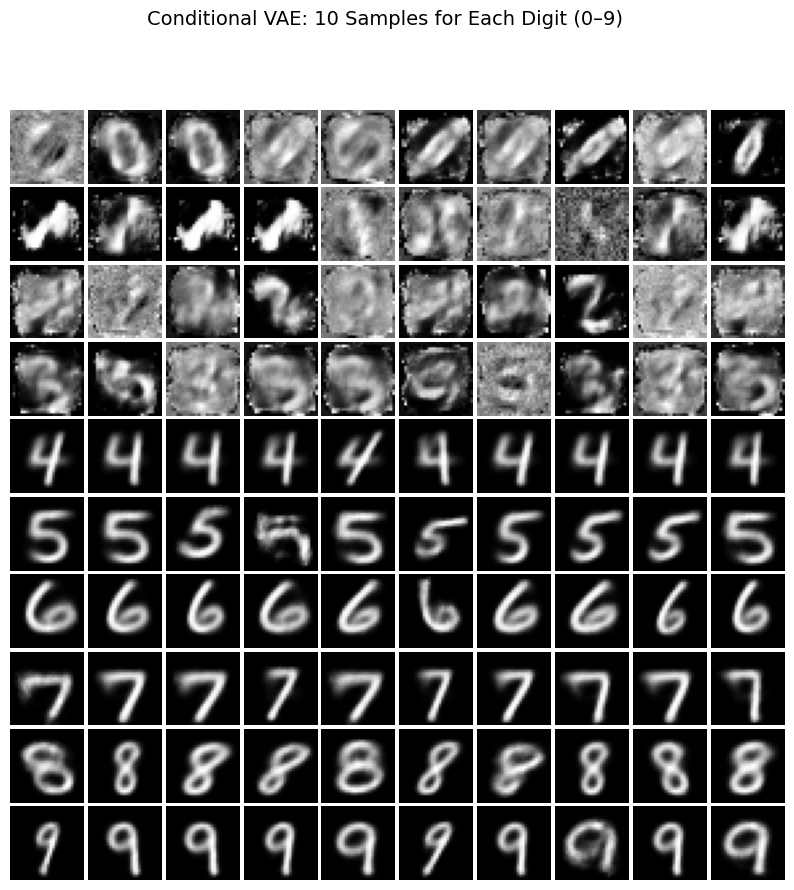

In [36]:
sa_model.eval()
n_samples_per_digit = 10
num_classes = 10

with torch.no_grad():
    z = torch.randn(num_classes * n_samples_per_digit, sa_model.latent_dim).to(device)
    y = torch.arange(0, num_classes).repeat_interleave(n_samples_per_digit).to(device)
    samples = sa_model.decode(z, y).view(-1, 1, 28, 28).cpu()
    
fig, axes = plt.subplots(num_classes, n_samples_per_digit, figsize=(10, 10))
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for i in range(num_classes):
    for j in range(n_samples_per_digit):
        ax = axes[i, j]
        ax.imshow(samples[i * n_samples_per_digit + j][0], cmap='gray')
        ax.axis('off')

plt.suptitle("Conditional VAE: 10 Samples for Each Digit (0–9)", fontsize=14)
plt.show()

In [29]:
def plot_generated_x_space(model, device, num_samples_per_class=200):
    model.eval()

    all_x = []
    all_y = []

    # Loop through digits 0–9
    for label in range(10):
        y = torch.full((num_samples_per_class,), label, dtype=torch.long, device=device)
        # Sample z ~ N(0, I)
        z = torch.randn(num_samples_per_class, model.latent_dim, device=device)

        # Decode → x samples
        with torch.no_grad():
            x_recon = model.decode(z, y)
            x_recon = torch.sigmoid(x_recon)  

        all_x.append(x_recon.cpu().view(num_samples_per_class, -1))
        all_y.append(y.cpu())

    all_x = torch.cat(all_x, dim=0).numpy()
    all_y = torch.cat(all_y, dim=0).numpy()

    print("Running t-SNE on generated samples (p(x | z, y))...")
    embedding = TSNE(n_components=2, perplexity=30, random_state=0).fit_transform(all_x)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=all_y, cmap='tab10', s=5)
    plt.colorbar(scatter, ticks=range(10))
    plt.title("t-SNE of generated samples (p(x | z, y)) for base model")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()


Running t-SNE on generated samples (p(x | z, y))...


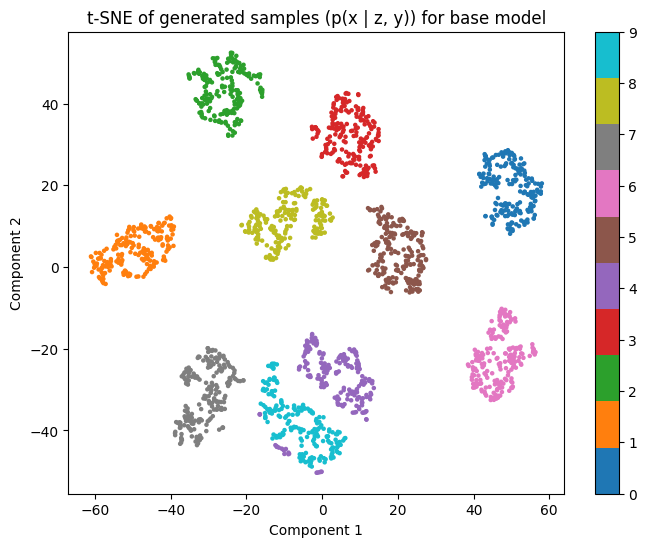

In [30]:
plot_generated_x_space(model2, device)

Running t-SNE on generated samples (p(x | z, y))...


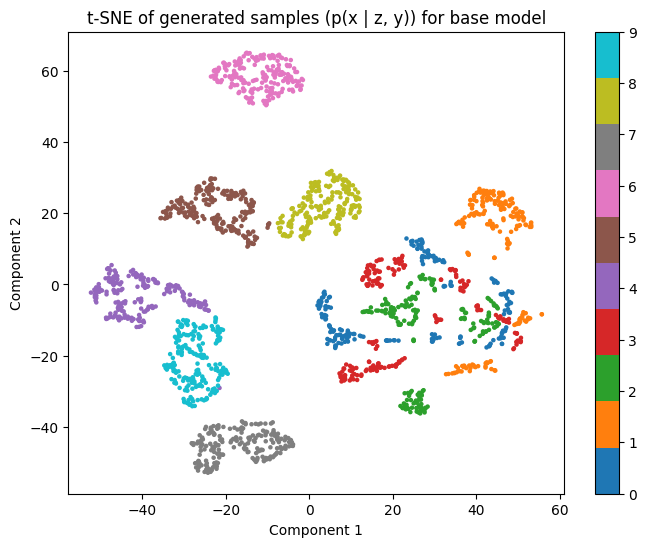

In [35]:
plot_generated_x_space(sa_model, device)